#Setup

In [ ]:
!pip install gym-gridworlds

In [ ]:
!pip install plotting

In [ ]:
!rm -r ../multiagentparticleenvs/
!git clone https://github.com/vlb9ae/multiagent-particle-envs.git

rm: cannot remove '../multiagentparticleenvs/': No such file or directory
Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 367 (delta 180), reused 170 (delta 170), pack-reused 170
Receiving objects: 100% (367/367), 123.53 KiB | 4.41 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [ ]:
%mv multiagent-particle-envs/ multiagentparticleenvs/

In [ ]:
%cd multiagentparticleenvs/

/content/multiagentparticleenvs


In [ ]:
!ls

bin  LICENSE.txt  make_env.py  multiagent  plotting_custom.py  README.md  setup.py


In [ ]:
!pip install gym==0.10.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 7.9 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581273 sha256=32eef62244d5c4709e59aa93cb9b3c9d64346acb0d05a702793cdc10a750b59a
  Stored in directory: /root/.cache/pip/wheels/f6/e4/3b/b3b32d8cdedd0e70545cc0a9139f3d66f8fd5d0c95d828d38e
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [ ]:
import gym
import gym_gridworlds
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd

In [ ]:
from plotting_custom import EpisodeStats

In [ ]:
%cd multiagentparticleenvs/

[Errno 2] No such file or directory: 'multiagentparticleenvs/'
/content/multiagentparticleenvs


In [ ]:
from multiagentparticleenvs.make_env import make_env

from collections import defaultdict
matplotlib.style.use('ggplot')

# env = make_env('extra_landmark_speaker_listener')
env = make_env('simpler_speaker_listener')
#env = make_env('simple_speaker_listener')
#env = make_env('simple')
#env = gym.make('Cliff-v0')

#Epsilon Greedy Policy Definition

In [ ]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based
    on a given Q-function and epsilon.

    Returns a function that takes the state
    as an input and returns the probabilities
    for each action in the form of a numpy array
    of length of the action space(set of possible actions).
    """
    def policyFunction(state):

        Action_probabilities = np.ones(num_actions,
                dtype = float) * epsilon / num_actions

        best_action = np.argmax(Q[state])
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    return policyFunction

#UCB Policy Definition

In [ ]:
def UCBPolicy(Q, N, c, t, state):

  best_action = 0
  best_q_val = float('-inf')
  for i in range(len(N)):
    if N[i] > 0:
      cur_q_val = Q[state][i] + c*np.sqrt(np.log(t)/N[i])
    else:
      cur_q_val = Q[state][i]
    if cur_q_val > best_q_val:
      best_q_val = cur_q_val
      best_action = i

  return best_action

#Communication counting helper

In [ ]:
def comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW):
  if np.array_equal(env.world.agents[0].goal_b.color, RED):
    if action == 0:
      communication_count[0] += 1
    if action == 1:
      communication_count[1] += 1
    if action == 2:
      communication_count[2] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
    if action == 0:
      communication_count[3] += 1
    if action == 1:
      communication_count[4] += 1
    if action == 2:
      communication_count[5] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
    if action == 0:
      communication_count[6] += 1
    if action == 1:
      communication_count[7] += 1
    if action == 2:
      communication_count[8] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
    if action == 0:
      communication_count[9] += 1
    if action == 1:
      communication_count[10] += 1
    if action == 2:
      communication_count[11] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
    if action == 0:
      communication_count[12] += 1
    if action == 1:
      communication_count[13] += 1
    if action == 2:
      communication_count[14] += 1
  if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
    if action == 0:
      communication_count[15] += 1
    if action == 1:
      communication_count[16] += 1
    if action == 2:
      communication_count[17] += 1

  return communication_count

#Normal qLearning

In [ ]:
def qLearning(env, num_episodes, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 0.1):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy"""

    # Action value function
    # A nested dictionary that maps
    # state -> (action -> action-value).

    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes))


    # Create an epsilon greedy policy function
    # appropriately for environment action space
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)

    # For every episode
    for ith_episode in range(num_episodes):

        # Reset the environment and pick the first action
        state = env.reset()
        print(state)

        for t in itertools.count():

            # get probabilities of all actions from current state
            action_probabilities = policy(state)

            # choose action according to
            # the probability distribution
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                       p = action_probabilities)

            # take action and get reward, transit to next state
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = t

            # TD Update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            # done is True if episode terminated
            if done:
                break

            state = next_state

    return Q, stats

#UCB_Microsoft

In [ ]:
def UCB_Microsoft(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    V = []
    N = []
    stats = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.ones(env.action_space[ind].n))))
      N.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))

      V.append(defaultdict(lambda: (0)))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )


    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    for ith_episode in range(num_episodes):

        #print("\n\nEpisode: ", ith_episode, "\n\n")

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy

            action = np.argmax(q[tuple(state)])
            #if action == 0 and ind == 1:
            #  action = np.random.choice(range(1, env.action_space[ind].n))

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1
              else:
                action_probabilities[i] = 0

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          #if t == 0:
          #  print(action_probs)

          next_state, reward, done, _ = env.step(action_probs)

          reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #stat.episode_rewards[ith_episode] += reward[ind]
            stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1


            #UCB-Hoeffding algorithm implementation with RUQL-style exponentiation of alpha terms
            temp = n[tuple(state)][action] + 1
            N[ind][tuple(state)][action] += 1

            alpha = (20 + 1)/(20 + temp)

            iota = np.log((25*env.action_space[ind].n*num_episodes*1000)/.1)

            bonus = .1*np.sqrt(((20))/temp)
            #q[tuple(state)][action] = """((1 - alpha)**(1/(action_probs[ind][action])))*"""(1 - alpha)*q[tuple(state)][action] + """(1 - (1-alpha)**(1/(action_probs[ind][action])))"""alpha*(reward[ind] + v[tuple(next_state[ind])] + bonus)
            """if ind == 1:
              print("State: ", tuple(state))
              print("Iota: ", iota)
              print("Bonus: ", bonus)
              print("Reward: ", reward[ind])
              print("Alpha: ", alpha)
              print("V-value: ", v[tuple(state)])
              print("N-value: ", N[ind][tuple(state)][action])"""
            Q[ind][tuple(state)][action] = (1 - alpha)*q[tuple(state)][action] + alpha*(reward[ind] + v[tuple(next_state[ind])])# + bonus)
            V[ind][tuple(state)] = min(np.max(Q[ind][tuple(state)]), 20)
            """if ind == 1:
              for a in range(env.action_space[ind].n):
                print("Q-value for action ", a, ": ", Q[ind][tuple(state)][a])"""

          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 10:
            #print("Reached end of episode")
            #stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]
            repeat_count = 0
            break

          prev_reward = reward[0]

    return Q, stats, communication_count

#UCB-Hoeffding


In [ ]:
def UCB_Hoeffding(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    V = []
    N = []
    stats = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (200*np.ones(env.action_space[ind].n))))
      N.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))

      V.append(defaultdict(lambda: (0)))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )


    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          #if (ith_episode / num_episodes > cutoff):
          #  cutoff += .1
          #  epsilon /= 2
            #env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            #action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))
            action = np.argmax(q[tuple(state)])

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1
              else:
                action_probabilities[i] = 0

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #stat.episode_rewards[ith_episode] += reward[ind]
            stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1


            #UCB-Hoeffding algorithm implementation
            temp = n[tuple(state)][action]
            n[tuple(state)][action] += 1

            if t > 0:
              iota = np.log((25*env.action_space[ind].n*num_episodes*t)/.1)
            else:
              iota = np.log((25*env.action_space[ind].n*num_episodes)/.1)
            bonus = 2*np.sqrt(((200**3)*iota)/temp)
            #print(type(v[tuple(next_state[ind])]))
            q[tuple(state)][action] = (1 - alpha)*q[tuple(state)][action] + alpha*(reward[ind] + v[tuple(next_state[ind])] + bonus)
            #print(np.argmax(q[tuple(state)]))
            v[tuple(state)] = np.argmax(q[tuple(state)])



            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            #left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
            #right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
            #best_next_action = np.argmax(q[tuple(next_state[ind])])
            #td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
            #right_term *= td_target
            #q[tuple(state)][action] = left_term + right_term

          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 10:
            #print("Reached end of episode")
            #stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]
            repeat_count = 0
            break

          prev_reward = reward[0]

    return Q, stats, communication_count

#UCB-Hoeffding with RUQL exponentiation


In [ ]:
def RUQL_UCB_Hoeffding(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    V = []
    N = []
    stats = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (20*np.ones(env.action_space[ind].n))))
      N.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))

      V.append(defaultdict(lambda: (0)))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )


    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    for ith_episode in range(num_episodes):

        print("\n\nEpisode: ", ith_episode, "\n\n")

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy

            action = np.argmax(q[tuple(state)])
            if action == 0 and ind == 1:
              action = np.random.choice(range(1, env.action_space[ind].n))

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1
              else:
                action_probabilities[i] = 0

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          #if t == 0:
          #  print(action_probs)

          next_state, reward, done, _ = env.step(action_probs)

          reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #stat.episode_rewards[ith_episode] += reward[ind]
            stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1


            #UCB-Hoeffding algorithm implementation with RUQL-style exponentiation of alpha terms
            temp = n[tuple(state)][action] + 1
            N[ind][tuple(state)][action] += 1

            alpha = (20 + 1)/(20 + temp)

            iota = np.log((25*env.action_space[ind].n*num_episodes*1000)/.1)

            bonus = 2*np.sqrt(((20**3)*iota)/temp)
            q[tuple(state)][action] = ((1 - alpha)**(1/(action_probs[ind][action])))*(1 - alpha)*q[tuple(state)][action] + (1 - (1-alpha)**(1/(action_probs[ind][action])))*(reward[ind] + v[tuple(next_state[ind])] + bonus)

            V[ind][tuple(state)] = min(np.max(Q[ind][tuple(state)]), 20)


          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 10:
            #print("Reached end of episode")
            #stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]
            repeat_count = 0
            break

          prev_reward = reward[0]

    return Q, stats, communication_count

#multi_agent_qLearning

In [ ]:
def MA_QL(env, num_episodes, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 0.1):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    stats = []
    policy = []

    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: np.zeros(env.action_space[ind].n)))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    prev_reward = 0
    repeat_count = 0
    t_vals = []
    non_zero_final = 0
    final_rewards = []
    for ith_episode in range(num_episodes):
        #print("On episode: ", ith_episode)
        states = env.reset()
        for t in itertools.count():
          #stores action probabilities assigned to each action at every step
          actions = []
          action_probs = []
          #loops through each agent
          for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, states, env.agents)):

            # get probabilities of all actions from current state for each agent
            action_probabilities = p(tuple(state))

            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                      p = action_probabilities)

            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1
              else:
                action_probabilities[i] = 0

            action_probs.append(action_probabilities)
            actions.append(action)


          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)
          #print(reward)
          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, states, env.agents)):
            # Update statistics
            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]

            #RUQL approximation algorithm, models Equation 4 from the paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent
            best_next_action = np.argmax(q[tuple(next_state[ind])])
            td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
            td_delta = td_target - q[tuple(state)][action]
            q[tuple(state)][action] += alpha * td_delta

          if prev_reward == reward[0]:
            repeat_count += 1
            #print("Reached repeat_count update")
          else:
            repeat_count = 0
          if repeat_count > 10: #or (ith_episode > 200 and t > 200):
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] != 0:
              #print("Final reward was: ", reward[0])
              non_zero_final += 1

            #print("Finished episode: ", ith_episode)
            repeat_count = 0
            break

          states = next_state

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (num_episodes - non_zero_final)/(num_episodes))

    return Q, stats

#Multi_agent_RUQL

In [ ]:
def RUQL(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    for ith_episode in range(num_episodes):

        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []

        if ith_episode > 0:
          alpha = (1000 + 1)/(1000 + ith_episode)

        if (ith_episode / num_episodes > cutoff):
          cutoff += .1
          epsilon /= 2
          env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

        for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, prev_state, env.agents)):

          #Create new policy function based on updated Q table for a given agent
          policy[ind] = createEpsilonGreedyPolicy(q, epsilon, env.action_space[ind].n)
          p = policy[ind]

          #Get probability distribution over actions from policy
          action_probabilities = p(tuple(state))

          #Choose an action using the probability distribution over actions
          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)

          #One-hot encode the chosen action so it is definitely chosen in env.step()
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0

          #action_probs -> stores one-hot encoded action for each agent
          action_probs.append(action_probabilities)
          #actions -> stores action chosen for each agent
          actions.append(action)

        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)

        #make rewards positive to allow policy function to choose argmin rather than argmax
        reward = np.asarray(reward)
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        #loops through each agent
        for ind, (q,stat, p,state,agent) in enumerate(zip(Q, stats, policy, prev_state, env.agents)):

          stat.episode_rewards[ith_episode] += reward[ind]
          stat.episode_lengths[ith_episode] = 1

          #choose action given probabilities for each agent
          action = actions[ind]
          if ind == 0:
            if np.array_equal(env.world.agents[0].goal_b.color, RED):
              if action == 0:
                communication_count[0] += 1
              if action == 1:
                communication_count[1] += 1
              if action == 2:
                communication_count[2] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
              if action == 0:
                communication_count[3] += 1
              if action == 1:
                communication_count[4] += 1
              if action == 2:
                communication_count[5] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
              if action == 0:
                communication_count[6] += 1
              if action == 1:
                communication_count[7] += 1
              if action == 2:
                communication_count[8] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
              if action == 0:
                communication_count[9] += 1
              if action == 1:
                communication_count[10] += 1
              if action == 2:
                communication_count[11] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
              if action == 0:
                communication_count[12] += 1
              if action == 1:
                communication_count[13] += 1
              if action == 2:
                communication_count[14] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
              if action == 0:
                communication_count[15] += 1
              if action == 1:
                communication_count[16] += 1
              if action == 2:
                communication_count[17] += 1


          if ind == 1:
            if q[tuple(state)].sum() == 0:
              unseen += 1

          # RUQL approximation algorithm, models Equation 4 from the RUQL paper
          #q -> q table for each agent
          #state -> state for each agent
          #action -> selected best action for each agent

          # RUQL
          left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
          right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
          best_next_action = np.argmin(q[tuple(next_state[ind])])
          td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
          right_term *= td_target
          q[tuple(state)][action] = left_term + right_term

        prev_state = next_state

    return Q, stats, unseen, communication_count

#RUQL with Bandit-style UCB exploration


In [ ]:
def RUQL_UCB_Bandit(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    non_zero_final = 0
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []
    final_rewards = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):

            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            # RUQL
            left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
            right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
            best_next_action = np.argmax(q[tuple(next_state[ind])])
            td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
            right_term *= td_target
            q[tuple(state)][action] = left_term + right_term

          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 10: #or (ith_episode > 200 and t > 200):
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] != 0:
              #print("Final reward was: ", reward[0])
              non_zero_final += 1

            #print("Finished episode: ", ith_episode)
            repeat_count = 0
            break

          prev_reward = reward[0]

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (num_episodes - non_zero_final)/(num_episodes))

    return Q, stats, communication_count

#RUQL vs. QL

In [ ]:
def RUQL_vs_QL(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    non_zero_final = 0
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []
    final_rewards = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy

            action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):


            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            # RUQL
            if ind == 1:
              left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
              right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
              best_next_action = np.argmax(q[tuple(next_state[ind])])
              td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
              right_term *= td_target
              q[tuple(state)][action] = left_term + right_term
            else:
              best_next_action = np.argmax(q[tuple(next_state[ind])])
              td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
              td_delta = td_target - q[tuple(state)][action]
              q[tuple(state)][action] += alpha * td_delta

          prev_state = next_state
          if repeat_count > 10:
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] == 0:
              non_zero_final += 1

            repeat_count = 0
            break
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0


          prev_reward = reward[0]

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (non_zero_final)/(num_episodes))

    return Q, stats, communication_count

#RUQL vs. Oracle

In [ ]:
def RUQL_vs_Oracle(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    non_zero_final = 0
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []
    final_rewards = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            if ind == 1:
              action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))
            else:
              if np.array_equal(env.world.agents[0].goal_b.color, RED):
                action = 0
              elif np.array_equal(env.world.agents[0].goal_b.color, BLUE):
                action = 1
              else:
                action = 2

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):


            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            # RUQL
            if ind == 1:
              left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
              right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
              best_next_action = np.argmax(q[tuple(next_state[ind])])
              td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
              right_term *= td_target
              q[tuple(state)][action] = left_term + right_term
            else:
              best_next_action = np.argmax(q[tuple(next_state[ind])])
              td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
              td_delta = td_target - q[tuple(state)][action]
              q[tuple(state)][action] += alpha * td_delta

          prev_state = next_state
          if repeat_count > 10:
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] == 0:
              non_zero_final += 1

            repeat_count = 0
            break
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0


          prev_reward = reward[0]

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (non_zero_final)/(num_episodes))

    return Q, stats, communication_count

#EXP3-DH

In [ ]:
def EXP3_DH(env, num_episodes, beta = 10, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    stats = []
    seen_states = []
    weights = []
    probs = []
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)))

      weights.append(np.zeros(env.action_space[ind].n))


      #calculate probabilities for each action
      prob = []
      for i in range(env.action_space[ind].n):
        term = (1 - epsilon)
        term *= np.exp(weights[ind][i])
        term *= 1/(np.sum(np.exp(weights[ind])))
        term += epsilon/env.action_space[ind].n
        prob.append(term)

      probs.append(prob)

    # For every episode
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    cutoff = .2

    for ith_episode in range(num_episodes):

        #Update epsilon based on time step
        if ith_episode > 0:
          epsilon = ith_episode ** (-.2)

        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []

        #For every cutoff % completion, change the color to ensure the speaker learns to change colors correctly
        if (ith_episode / num_episodes > cutoff):
          cutoff += .2
          env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

        for ind, (weight, stat, state, agent) in enumerate(zip(weights, stats, prev_state, env.agents)):

          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Calculate probabilities for each action using equation defined in Step 4 of the algorithm
          p = []
          for i in range(K):
            p_i = (1 - epsilon)
            p_i *= np.exp(weight[i] - np.max(weight))
            p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
            if p_i == float("inf"):
              print("Infinity weights", weight)
            p_i += epsilon/K
            p.append(p_i)

          probs[ind] = p

          #Define action_probabilities to be the probability distribution over actions
          action_probabilities = np.asarray(p)

          #Choose an action using the probability distribution over actions
          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)


          #print(action_probabilities)
          #One-hot encode the chosen action so it is definitely chosen in env.step()
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0

          #action_probs -> stores one-hot encoded action for each agent
          action_probs.append(action_probabilities)
          #actions -> stores action chosen for each agent
          actions.append(action)

        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)

        #make rewards positive to allow policy function to choose argmin rather than argmax
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        reward = np.asarray(reward)
        #loops through each agent
        for ind, (stat, prob, state, agent) in enumerate(zip(stats, probs, prev_state, env.agents)):

          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Update statistics with rewards
          stat.episode_rewards[ith_episode] += reward[ind]
          stat.episode_lengths[ith_episode] = 1

          #choose action given probabilities for each agent
          action = actions[ind]


          #Calculate payoff estimate for each action (0 for every non-chosen action)
          payoff_estimate = []
          for i in range(K):
            if i == action:
              payoff_estimate.append(reward[ind]/prob[i])
            else:
              payoff_estimate.append(0)

          #Calculate weight for each action using Equation 8 in algorithm
          weight = []
          for i in range(K):
            weight.append((ith_episode/(ith_episode + 1))**(beta)*weights[ind][i] + payoff_estimate[i])

          weights[ind] = np.asarray(weight)


          if ind == 0:
            if np.array_equal(env.world.agents[0].goal_b.color, RED):
              if action == 0:
                communication_count[0] += 1
              if action == 1:
                communication_count[1] += 1
              if action == 2:
                communication_count[2] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
              if action == 0:
                communication_count[3] += 1
              if action == 1:
                communication_count[4] += 1
              if action == 2:
                communication_count[5] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
              if action == 0:
                communication_count[6] += 1
              if action == 1:
                communication_count[7] += 1
              if action == 2:
                communication_count[8] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
              if action == 0:
                communication_count[9] += 1
              if action == 1:
                communication_count[10] += 1
              if action == 2:
                communication_count[11] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
              if action == 0:
                communication_count[12] += 1
              if action == 1:
                communication_count[13] += 1
              if action == 2:
                communication_count[14] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
              if action == 0:
                communication_count[15] += 1
              if action == 1:
                communication_count[16] += 1
              if action == 2:
                communication_count[17] += 1


        prev_state = next_state

    return stats, communication_count

#RUQL vs. EXP3-DH

In [ ]:
def RUQL_vs_EXP3_DH(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01, beta = 10):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    non_zero_final = 0
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))

      if ind == 0:
        weight = np.zeros(env.action_space[ind].n)

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []
    final_rewards = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            if ind == 1:
              action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))
            else:
              #Define K to be the number of actions for the current agent
              K = env.action_space[ind].n

              #Calculate probabilities for each action using equation defined in Step 4 of the algorithm
              p = []
              for i in range(K):
                p_i = (1 - epsilon)
                p_i *= np.exp(weight[i] - np.max(weight))
                p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
                if p_i == float("inf"):
                  print("Infinity weights", weight)
                p_i += epsilon/K
                p.append(p_i)

              #Define action_probabilities to be the probability distribution over actions
              action_probabilities = np.asarray(p)

              #Choose an action using the probability distribution over actions
              action = np.random.choice(np.arange(
                        len(action_probabilities)),
                        p = action_probabilities)

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):


            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            # RUQL
            if ind == 1:
              left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
              right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
              best_next_action = np.argmax(q[tuple(next_state[ind])])
              td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
              right_term *= td_target
              q[tuple(state)][action] = left_term + right_term
            else:
              payoff_estimate = []
              for i in range(K):
                if i == action:
                  payoff_estimate.append(reward[ind]/p[i])
                else:
                  payoff_estimate.append(0)

              #Calculate weight for each action using Equation 8 in algorithm
              weights = []
              for i in range(K):
                weights.append((t/(t + 1))**(beta)*weight[i] + payoff_estimate[i])

              weight = np.asarray(weights)
              #print(weight)

          prev_state = next_state
          if repeat_count > 10: #or (ith_episode > 200 and t > 200):
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] == 0:
              non_zero_final += 1

            repeat_count = 0
            break
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0


          prev_reward = reward[0]

        #print("Finished episode: ", ith_episode)

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (non_zero_final)/(num_episodes))

    return Q, stats, communication_count

#RUQL vs. EXP3-DH with 3 instances

In [ ]:
def RUQL_vs_EXP3_DH_3(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01, beta = 10):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    non_zero_final = 0
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))
      if ind == 0:
        weights = np.asarray([np.zeros(env.action_space[ind].n), np.zeros(env.action_space[ind].n), np.zeros(env.action_space[ind].n)])

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []
    final_rewards = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            if ind == 1:
              action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))
            else:
              #Define K to be the number of actions for the current agent
              K = env.action_space[ind].n
              if np.array_equal(env.world.agents[0].goal_b.color, RED):
                weight = weights[0]
              elif np.array_equal(env.world.agents[0].goal_b.color, BLUE):
                weight = weights[1]
              else:
                weight = weights[2]
              #Calculate probabilities for each action using equation defined in Step 4 of the algorithm
              p = []
              for i in range(K):
                p_i = (1 - epsilon)
                p_i *= np.exp(weight[i] - np.max(weight))
                p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
                if p_i == float("inf"):
                  print("Infinity weights", weight)
                p_i += epsilon/K
                p.append(p_i)

              #Define action_probabilities to be the probability distribution over actions
              action_probabilities = np.asarray(p)

              #Choose an action using the probability distribution over actions
              action = np.random.choice(np.arange(
                        len(action_probabilities)),
                        p = action_probabilities)

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):


            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            # RUQL
            if ind == 1:
              left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
              right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
              best_next_action = np.argmax(q[tuple(next_state[ind])])
              td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
              right_term *= td_target
              q[tuple(state)][action] = left_term + right_term
            else:
              payoff_estimate = []
              for i in range(K):
                if i == action:
                  payoff_estimate.append(reward[ind]/p[i])
                else:
                  payoff_estimate.append(0)

              #Calculate weight for each action using Equation 8 in algorithm
              new_weights = []
              for i in range(K):
                new_weights.append((t/(t + 1))**(beta)*weight[i] + payoff_estimate[i])

              if np.array_equal(env.world.agents[0].goal_b.color, RED):
                weights[0] = np.asarray(new_weights)
              elif np.array_equal(env.world.agents[0].goal_b.color, BLUE):
                weights[1] = np.asarray(new_weights)
              else:
                weights[2] = np.asarray(new_weights)
              #print(weight)

          prev_state = next_state
          if repeat_count > 10: #or (ith_episode > 200 and t > 200):
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] == 0:
              non_zero_final += 1
            repeat_count = 0
            break
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0


          prev_reward = reward[0]

        #print("Finished episode: ", ith_episode)

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (non_zero_final)/(num_episodes))

    return Q, stats, communication_count

#EXP3

In [ ]:
def EXP3(env, num_episodes, beta = 10, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    stats = []
    seen_states = []
    weights = []
    probs = []
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)))

      weights.append(np.zeros(env.action_space[ind].n))


      #calculate probabilities for each action
      prob = []
      for i in range(env.action_space[ind].n):
        term = (1 - epsilon)
        term *= np.exp(weights[ind][i])
        term *= 1/(np.sum(np.exp(weights[ind])))
        term += epsilon/env.action_space[ind].n
        prob.append(term)

      probs.append(prob)

    # For every episode
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    cutoff = .2

    for ith_episode in range(num_episodes):

        #Update epsilon based on time step
        if ith_episode > 0:
          epsilon = ith_episode ** (-.2)

        #stores action probabilities assigned to each action at every step
        actions = []
        action_probs = []

        #For every cutoff % completion, change the color to ensure the speaker learns to change colors correctly
        if (ith_episode / num_episodes > cutoff):
          cutoff += .2
          env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

        for ind, (weight, stat, state, agent) in enumerate(zip(weights, stats, prev_state, env.agents)):

          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Calculate probabilities for each action using equation defined in Step 4 of the algorithm
          p = []
          for i in range(K):
            p_i = (1 - epsilon)
            p_i *= np.exp(weight[i] - np.max(weight))
            p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
            if p_i == float("inf"):
              print("Infinity weights", weight)
            p_i += epsilon/K
            p.append(p_i)

          probs[ind] = p

          #Define action_probabilities to be the probability distribution over actions
          action_probabilities = np.asarray(p)

          #Choose an action using the probability distribution over actions
          action = np.random.choice(np.arange(
                    len(action_probabilities)),
                    p = action_probabilities)


          #print(action_probabilities)
          #One-hot encode the chosen action so it is definitely chosen in env.step()
          for i in range(len(action_probabilities)):
            if i == action:
              action_probabilities[i] = 1
            else:
              action_probabilities[i] = 0

          #action_probs -> stores one-hot encoded action for each agent
          action_probs.append(action_probabilities)
          #actions -> stores action chosen for each agent
          actions.append(action)

        #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
        next_state, reward, done, _ = env.step(action_probs)

        #make rewards positive to allow policy function to choose argmin rather than argmax
        #next_state -> set of states for each agent
        #reward -> array of rewards for each agent
        #done -> whether or not learning is finished
        reward = np.asarray(reward)
        #loops through each agent
        for ind, (stat, prob, state, agent) in enumerate(zip(stats, probs, prev_state, env.agents)):

          #Define K to be the number of actions for the current agent
          K = env.action_space[ind].n

          #Update statistics with rewards
          stat.episode_rewards[ith_episode] += reward[ind]
          stat.episode_lengths[ith_episode] = 1

          #choose action given probabilities for each agent
          action = actions[ind]


          #Calculate payoff estimate for each action (0 for every non-chosen action)
          payoff_estimate = []
          for i in range(K):
            if i == action:
              payoff_estimate.append(reward[ind]/prob[i])
            else:
              payoff_estimate.append(0)

          #Calculate weight for each action using Equation 8 in algorithm

          weights[ind] = np.asarray(weights[ind])*np.exp(epsilon*np.asarray(payoff_estimate)/K)


          if ind == 0:
            if np.array_equal(env.world.agents[0].goal_b.color, RED):
              if action == 0:
                communication_count[0] += 1
              if action == 1:
                communication_count[1] += 1
              if action == 2:
                communication_count[2] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, GREEN):
              if action == 0:
                communication_count[3] += 1
              if action == 1:
                communication_count[4] += 1
              if action == 2:
                communication_count[5] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, BLUE):
              if action == 0:
                communication_count[6] += 1
              if action == 1:
                communication_count[7] += 1
              if action == 2:
                communication_count[8] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, CYAN):
              if action == 0:
                communication_count[9] += 1
              if action == 1:
                communication_count[10] += 1
              if action == 2:
                communication_count[11] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, MAGENTA):
              if action == 0:
                communication_count[12] += 1
              if action == 1:
                communication_count[13] += 1
              if action == 2:
                communication_count[14] += 1
            if np.array_equal(env.world.agents[0].goal_b.color, YELLOW):
              if action == 0:
                communication_count[15] += 1
              if action == 1:
                communication_count[16] += 1
              if action == 2:
                communication_count[17] += 1


        prev_state = next_state

    return stats, communication_count

#V-OL

In [ ]:
def V_OL(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01, beta = 10, eta = .01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    non_zero_final = 0
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    H = 200
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (200)))

      N.append(defaultdict(lambda: (0)))

      if ind == 0:
        weight = np.zeros(env.action_space[ind].n)

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append((1/env.action_space[ind].n)*np.ones(env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []
    final_rewards = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            iota = np.log((121*env.action_space[0].n*num_episodes*t)/.1)
            alpha = (H + 1)/(H + t)
            beta = np.sqrt((H**4*env.action_space[0].n*iota)/t)
            eta = np.sqrt(np.log(env.action_space[0].n)/(env.action_space[0].n*t))

          for ind, (q,p,stat, n, v, state,agent) in enumerate(zip(Q, policy,stats, N, V, prev_state, env.agents)):


            #Define action_probabilities to be the probability distribution over actions
            action_probabilities = np.asarray(p)
            print(action_probabilities)

            #Choose an action using the probability distribution over actions
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                      p = action_probabilities)

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          #reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q, p, stat, state,agent) in enumerate(zip(Q, policy, stats, prev_state, env.agents)):


            stat.episode_rewards[ith_episode] += reward[ind]
            #stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent
            N[ind][tuple(state)] += 1
            V[ind][tuple(state)] = (1-alpha)*V[ind][tuple(state)] + alpha*(reward[ind] + V[ind][tuple(next_state[ind])] + beta)
            for i in range(env.action_space[ind].n):
              if action == i:
                Q[ind][tuple(state)][i] = (1 - alpha)*Q[ind][tuple(state)][i] + alpha*(200 - reward[ind] - V[ind][tuple(next_state[ind])])/(policy[ind][action] + eta)
              else:
                Q[ind][tuple(state)][i] = (1 - alpha)*Q[ind][tuple(state)][i]

            for i in range(env.action_space[ind].n):
              policy[ind][i] = (np.exp(-eta*Q[ind][tuple(state)][i]/alpha))/np.sum(np.exp(-eta*Q[ind][tuple(state)]/alpha))
              print("V-value for action ", i, "and agent ", ind, ": ", Q[ind][tuple(state)][i])
              print("Policy for action ", i, " and agent ", ind, ": ", policy[ind][i])

          prev_state = next_state
          if repeat_count > 10: #or (ith_episode > 200 and t > 200):
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            t_vals.append(t)
            final_rewards.append(reward[0])
            if reward[0] == 0:
              non_zero_final += 1

            repeat_count = 0
            break
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0


          prev_reward = reward[0]

        #print("Finished episode: ", ith_episode)

    print("Average H value: ", np.average(np.asarray(t_vals)))
    print("Average final reward: ", np.average(np.asarray(final_rewards)))
    print("Convergence rate: ", (non_zero_final)/(num_episodes))

    return Q, stats, communication_count

#Results

In [ ]:
e = 1000
#MA_QL_Q, MA_QL_stats = MA_QL(env, e)
#V_OL_Q, V_OL_stats = V_OL(env, e)
RUQL_UCB_BANDIT_Q, RUQL_UCB_BANDIT_stats, RUQL_UCB_BANDIT_comm = RUQL_UCB_Bandit(env, e)
#UCB_Hoeffding_Q, UCB_Hoeffding_stats, UCB_Hoeffding_comm = UCB_Hoeffding(env, e)
#RUQL_vs_QL_Q, RUQL_vs_QL_stats, RUQL_vs_QL_comm = RUQL_vs_QL(env, e)
#RUQL_vs_Oracle_Q, RUQL_vs_Oracle_stats, RUQL_vs_Oracle_comm = RUQL_vs_Oracle(env, e)
#RUQL_vs_EXP3_DH_Q, RUQL_vs_EXP3_DH_stats, RUQL_vs_EXP3_DH_comm = RUQL_vs_EXP3_DH(env, e)
#RUQL_vs_EXP3_DH_3_Q, RUQL_vs_EXP3_DH_3_stats, RUQL_vs_EXP3_DH_3_comm = RUQL_vs_EXP3_DH_3(env, e)
#RUQL_UCB_Hoeffding_Q, RUQL_UCB_Hoeffding_stats, RUQL_UCB_Hoeffding_comm = RUQL_UCB_Hoeffding(env, e)
#UCB_Microsoft_Q, UCB_Microsoft_stats, UCB_Microsoft_comm = UCB_Microsoft(env, e)
#print(RUQL_UCB_Hoeffding_comm)

KeyboardInterrupt: 

In [ ]:
import plotting_custom
for ind, stat in enumerate(RUQL_UCB_BANDIT_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(RUQL_UCB_BANDIT_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import plotting_custom
for ind, stat in enumerate(UCB_Hoeffding_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(UCB_Hoeffding_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import plotting_custom
for ind, stat in enumerate(MA_QL_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(MA_QL_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import plotting_custom
for ind, stat in enumerate(RUQL_vs_QL_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(RUQL_vs_QL_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import plotting_custom
for ind, stat in enumerate(UCB_Microsoft_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(UCB_Microsoft_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
locs = [4*i for i in range(9)]
plt.bar(locs, RUQL_UCB_comm, color=['red', 'red', 'red', 'green', 'green', 'green', 'blue', 'blue', 'blue'], width=[3.75 for _ in range(9)])#, 'cyan', 'cyan', 'cyan', 'magenta', 'magenta', 'magenta', 'yellow', 'yellow', 'yellow'], width=[3.75 for _ in range(9)])
plt.xticks(locs, ['red+0', 'red+1', 'red+2', 'green+0', 'green+1', 'green+2', 'blue+0', 'blue+1', 'blue+2'])#,'cyan+0', 'cyan+1', 'cyan+2', 'magenta+0', 'magenta+1', 'magenta+2', 'yellow+0', 'yellow+1', 'yellow+2'])
plt.show()

In [ ]:
import plotting_custom
for ind, stat in enumerate(RUQL_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(RUQL_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
locs = [4*i for i in range(9)]
plt.bar(locs, RUQL_comm, color=['red', 'red', 'red', 'green', 'green', 'green', 'blue', 'blue', 'blue'], width=[3.75 for _ in range(9)])#, 'cyan', 'cyan', 'cyan', 'magenta', 'magenta', 'magenta', 'yellow', 'yellow', 'yellow'], width=[3.75 for _ in range(9)])
plt.xticks(locs, ['red+0', 'red+1', 'red+2', 'green+0', 'green+1', 'green+2', 'blue+0', 'blue+1', 'blue+2'])#,'cyan+0', 'cyan+1', 'cyan+2', 'magenta+0', 'magenta+1', 'magenta+2', 'yellow+0', 'yellow+1', 'yellow+2'])
plt.show()

In [ ]:
import plotting_custom
for ind, stat in enumerate(EXP3_DH_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(EXP3_DH_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

In [ ]:
import plotting_custom
for ind, stat in enumerate(EXP3_stats):

  print("Stats for agent {}".format(ind))
  print(f"Average reward for agent {ind}: " + str(np.mean(EXP3_stats[ind].episode_rewards)))
  plotting_custom.plot_episode_stats(stat)

#MADDPG Implementation

In [ ]:
%cd ../
!git clone https://github.com/lab-sigma/cooperative-ML.git

/content
Cloning into 'cooperative-ML'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 67 (delta 22), reused 57 (delta 15), pack-reused 0
Receiving objects: 100% (67/67), 454.77 KiB | 7.98 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
%cd ./cooperative-ML/multiagent-particle-envs/maddpg/experiments

/content/cooperative-ML/multiagent-particle-envs/maddpg/experiments


In [ ]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling t

In [ ]:
!python train.py --scenario simple_speaker_listener --num-episodes 5000 --exp-name simple_speaker_listener --max-episode-len 200

2024-06-18 05:31:13.794210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 05:31:13.794311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 05:31:13.796451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 05:31:13.839748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 05:31:15.356956: W tensorflow/compiler/tf2

#Centralized Training Implementation


In [ ]:
def RUQL_centralized(env, num_episodes, discount_factor = 0.9,
                            alpha = 0.01, epsilon = 0.01):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    V = []
    N = []
    stats = []
    policy = []
    seen_states = []
    unseen = 0
    #Loop through each agent in the environment
    for ind, agent in enumerate(env.agents):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: (np.zeros(env.action_space[ind].n))))
      V.append(defaultdict(lambda: (0)))

      N.append(np.zeros(env.action_space[ind].n))

      # Keeps track of useful statistics for each agent
      stats.append( EpisodeStats(
          episode_lengths = np.zeros(num_episodes),
          episode_rewards = np.zeros(num_episodes)) )

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[ind], epsilon, env.action_space[ind].n))

    # For every episode
    cutoff = .1
    prev_state = env.reset()

    # red+0, red+1, red+2, green+0, green+1, green+2, blue+0, blue+1, blue+2,
    # cyan+0, cyan+1, cyan+2, magenta+0, magenta+1, magenta+2, yellow+0, yellow+1, yellow+2
    communication_count = [0 for _ in range(9)]
    RED = np.array([0.65, 0.15, 0.15])
    GREEN = np.array([0.15, 0.65, 0.15])
    BLUE = np.array([0.15, 0.15, 0.65])
    CYAN = np.array([0.15, 0.65, 0.65])
    MAGENTA = np.array([0.65, 0.15, 0.65])
    YELLOW = np.array([0.65, 0.65, 0.15])

    prev_reward = 0
    repeat_count = 0

    t_vals = []

    for ith_episode in range(num_episodes):

        prev_state = env.reset()

        for t in itertools.count():
          actions = []
          action_probs = []

          if t > 0:
            alpha = (200 + 1)/(200 + t)

          #if (ith_episode / num_episodes > cutoff):
          #  cutoff += .1
          #  epsilon /= 2
            #env.world.agents[0].goal_b = np.random.choice(env.world.landmarks)

          for ind, (q,stat, n, v, state,agent) in enumerate(zip(Q, stats, N, V, prev_state, env.agents)):

            #Choose an action using the UCB policy
            action = UCBPolicy(q, n, 2, v[tuple(state)], tuple(state))

            action_probabilities = np.zeros(env.action_space[ind].n)

            #One-hot encode the chosen action so it is definitely chosen in env.step()
            for i in range(len(action_probabilities)):
              if i == action:
                action_probabilities[i] = 1

            #action_probs -> stores one-hot encoded action for each agent
            action_probs.append(action_probabilities)
            #actions -> stores action chosen for each agent
            actions.append(action)

          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          next_state, reward, done, _ = env.step(action_probs)

          full_state = np.concatenate(prev_state[0], prev_state[1])

          reward = (np.asarray(reward)/242)+1
          #next_state -> set of states for each agent
          #reward -> array of rewards for each agent
          #done -> whether or not learning is finished
          #loops through each agent
          for ind, (q,stat, state,agent) in enumerate(zip(Q, stats, prev_state, env.agents)):

            #stat.episode_rewards[ith_episode] += reward[ind]
            stat.episode_rewards[ith_episode] = reward[ind]
            stat.episode_lengths[ith_episode] = t

            #choose action given probabilities for each agent
            action = actions[ind]
            if ind == 0:
              communication_count = comm_count_update(env, action, communication_count, RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

            if ind == 1:
              if q[tuple(state)].sum() == 0:
                unseen += 1

            # RUQL approximation algorithm, models Equation 4 from the RUQL paper
            #q -> q table for each agent
            #state -> state for each agent
            #action -> selected best action for each agent

            # RUQL
            left_term = (1-alpha)**(1/(action_probs[ind][action]))*q[tuple(state)][action]
            right_term = 1 - (1-alpha)**(1/(action_probs[ind][action]))
            best_next_action = np.argmax(q[tuple(next_state[ind])])
            td_target = reward[ind] + discount_factor * q[tuple(next_state[ind])][best_next_action]
            right_term *= td_target
            q[tuple(state)][action] = left_term + right_term

          prev_state = next_state
          if prev_reward == reward[0]:
            repeat_count += 1
          else:
            repeat_count = 0
          if repeat_count > 10:
            #print("Reached end of episode")
            #stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]/t
            stat.episode_rewards[ith_episode] = stat.episode_rewards[ith_episode]
            repeat_count = 0
            break

          prev_reward = reward[0]

    print("Average H value", np.average(np.asarray(t_vals)))

    return Q, stats, communication_count

#Bayesian Persuasion Game

In [ ]:
#np.set_printoptions(suppress=False)
np.set_printoptions(suppress=True)
import cvxpy as cp
num_states = 2
num_signals = num_actions = 2

state_prior = np.asarray([0.3, 0.7])  ### state { guilty, innocent}

s = np.asarray([[1,1], [0,0]]) ### state x action
r = np.asarray([[1,0], [0,1]])


x = cp.Variable( num_states*num_signals )
s_flat = np.reshape(s, num_states*num_signals )
obj = cp.Maximize( cp.matmul(x, s_flat)  )

P = cp.reshape(x, (num_states, num_signals) )
p1 = cp.sum(P, axis=1)
constraints =  [p1 == state_prior, x >= 0]

for i in range(num_actions):
	for j in range(num_actions):
		constraints.append( cp.matmul(P[:,i], r[:,i]) >=  cp.matmul(P[:,i], r[:,j]) )

lp = cp.Problem(obj, constraints)
lp.solve()

print("LP results: ==============\n")
print("status: " + str(lp.status) + "\n")
print(P.value.T / state_prior)

LP results: ==============

status: optimal

[[ 1.          0.42857143]
 [-0.          0.57142857]]


In [ ]:
prior_dist = np.asarray([.7, .3])
state = np.random.choice([0, 1], p=prior_dist)

def reward(state, choice):
  if state == 0 and choice == 0:
    return [1, 1]
  elif state == 1 and choice == 0:
    return [1, 0]
  elif state == 0 and choice == 1:
    return [0, 0]
  elif state == 1 and choice == 1:
    return [0, 1]

In [ ]:
zero_zero_probs = []
zero_one_probs = []
one_zero_probs = []
one_one_probs = []
def BP_EXP3(num_rounds, prior_dist, discount_factor = .6, alpha = 0.6, epsilon = 0.1, beta = 4):
  weights = [[], []]
  for i in range(2):
    weights[i] = [np.asarray([0, 0]), np.asarray([0, 0])]

  states = [np.random.choice([0, 1], p=prior_dist), 0]
  next_states = states
  index = 0
  actions = [0, 0]
  zero_rounds = 0
  truthful_zero_rounds = 0
  one_rounds = 0
  truthful_one_rounds = 0
  K = 2
  for t in range(num_rounds):
    if t % 2 == 0:
      index = 0
    else:
      index = 1
      states[1] = actions[0]

    #if t > 0:
    #  epsilon = t ** (-.2)

    state = states[index]
    weight = weights[index][state]
    #print("Weights: ", weights)
    if index == 0:
      p_vals = [[], []]
    p = []

    for i in range(K):
      #print("Weight for action ", i, " for agent ", index, ": ", weight[i])
      p_i = (1 - epsilon)
      p_i *= np.exp(weight[i] - np.max(weight))
      p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
      #print("p_i: ", p_i)
      p_i += epsilon/K
      p.append(p_i)

    action_probabilities = np.asarray(p)

    p_vals[index] = action_probabilities

    action = np.random.choice(np.arange(
            len(action_probabilities)),
            p = action_probabilities)

    if index == 0:
      #print("Prosecutor sent signal ", action, " on episode ", t/2, " with state of nature: ", state)
      if state == 0:
        zero_rounds += 1
        if action == 0:
          truthful_zero_rounds += 1
        zero_zero_probs.append(p[0])
        zero_one_probs.append(p[1])
      else:
        one_rounds += 1
        if action == 1:
          truthful_one_rounds += 1
        one_zero_probs.append(p[0])
        one_one_probs.append(p[1])

    actions[index] = action

    if index == 1:
      #print("State: ", states[0])
      #if states[0] == 0:

      other_p = []
      other_state = int(not states[0])
      other_weight = weights[index][state]
      for i in range(K):
        #print("Weight for action ", i, " for agent ", index, ": ", other_weight[i])
        p_i = (1 - epsilon)
        p_i *= np.exp(other_weight[i] - np.max(other_weight))
        p_i *= 1/(np.sum(np.exp(other_weight - np.max(other_weight))))
        #print("p_i: ", p_i)
        p_i += epsilon/K
        other_p.append(p_i)

      sums = []
      for i in range(2):
        pi = p_vals[0]
        p_theta_1 = pi[actions[0]]*prior_dist[states[0]]/(prior_dist[states[0]]*p_vals[index][states[1]] + prior_dist[other_state]*other_p[states[1]])
        #print("p_theta_1: ", p_theta_1)
        r_1 = reward(states[0], i)[1]
        p_theta_2 = pi[actions[0]]*prior_dist[other_state]/(prior_dist[other_state]*p_vals[index][states[1]] + prior_dist[states[0]]*other_p[states[1]])
        r_2 = reward(other_state, i)[1]
        sum = p_theta_1*r_1 + p_theta_2*r_2
        sums.append(sum)

      actions[1] = sums.index(max(sums))


      #print("Action taken by sender: ", states[1])
      #print("Action probabilities for the sender: ", p_vals[0], " for state ", states[0])
      #print("Action probabilities for the receiver: ", p_vals[1], " for state ", states[0])

      rewards = reward(states[0], actions[1])

      payoff_estimates = [[], []]

      for agent in range(2):
        for i in range(K):
          if i == actions[agent]:
            payoff_estimates[agent].append(rewards[agent]/p_vals[agent][i])
          else:
            payoff_estimates[agent].append(0)

      #print("Payoff estimates: ", payoff_estimates)

      new_weights = [[], []]

      for agent in range(2):
        for i in range(K):
          new_weights[agent].append((t/(t + 1))**(beta)*weights[agent][states[agent]][i] + payoff_estimates[agent][i])
        weights[agent][states[agent]] = new_weights[agent]

      states = [np.random.choice([0, 1], p=prior_dist), 0]

  print("Weights: ", weights)
  weight = weights[0][0]
  p = []
  for i in range(K):
    #print("Weight for action ", i, " for agent ", index, ": ", weight[i])
    p_i = (1 - epsilon)
    p_i *= np.exp(weight[i] - np.max(weight))
    p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
    #print("p_i: ", p_i)
    p_i += epsilon/K
    p.append(p_i)
  print("Prosecutor probabilities if client is guilty: ", p)
  weight = weights[0][1]
  p = []
  for i in range(K):
    #print("Weight for action ", i, " for agent ", index, ": ", weight[i])
    p_i = (1 - epsilon)
    p_i *= np.exp(weight[i] - np.max(weight))
    p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
    #print("p_i: ", p_i)
    p_i += epsilon/K
    p.append(p_i)
  print("Prosecutor probabilities if client is innocent: ", p)
  weight = weights[1][0]
  p = []
  for i in range(K):
    #print("Weight for action ", i, " for agent ", index, ": ", weight[i])
    p_i = (1 - epsilon)
    p_i *= np.exp(weight[i] - np.max(weight))
    p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
    #print("p_i: ", p_i)
    p_i += epsilon/K
    p.append(p_i)
  print("Judge probabilities if signal is 0: ", p)
  weight = weights[1][1]
  p = []
  for i in range(K):
    #print("Weight for action ", i, " for agent ", index, ": ", weight[i])
    p_i = (1 - epsilon)
    p_i *= np.exp(weight[i] - np.max(weight))
    p_i *= 1/(np.sum(np.exp(weight - np.max(weight))))
    #print("p_i: ", p_i)
    p_i += epsilon/K
    p.append(p_i)
  print("Judge probabilities if signal is 1: ", p)
  if zero_rounds > 0:
    print("\n\nProsecutor truthfully reported guilty with a ratio of: ", truthful_zero_rounds/zero_rounds)
  if one_rounds > 0:
    print("Prosecutor truthfully reported innocent with a ratio of: ", truthful_one_rounds/one_rounds)

BP_EXP3(1000, prior_dist)


Weights:  [[[104.62153228199773, 146.11910783018138], [121.15146918982292, 130.73071586061295]], [[31.483860024229003, 0.0], [121.03862315033075, 0.0]]]
Prosecutor probabilities if client is guilty:  [0.05, 0.9500000000000001]
Prosecutor probabilities if client is innocent:  [0.0500622298149473, 0.9499377701850529]
Judge probabilities if signal is 0:  [0.9499999999999809, 0.0500000000000191]
Judge probabilities if signal is 1:  [0.9500000000000001, 0.05]


Prosecutor truthfully reported guilty with a ratio of:  0.23372781065088757
Prosecutor truthfully reported innocent with a ratio of:  0.6111111111111112


Text(0.5, 1.0, 'Probabilities over rounds for sending signal 1 given state 1')

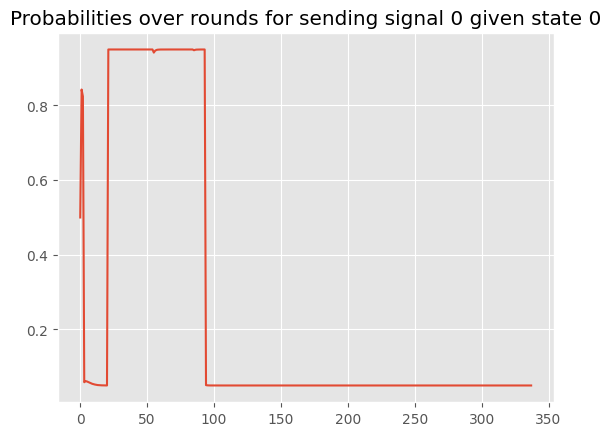

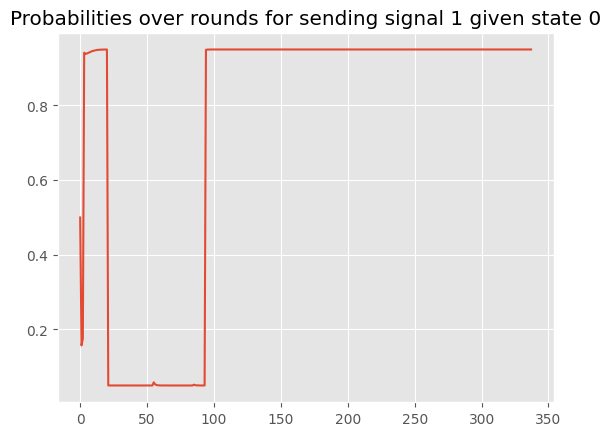

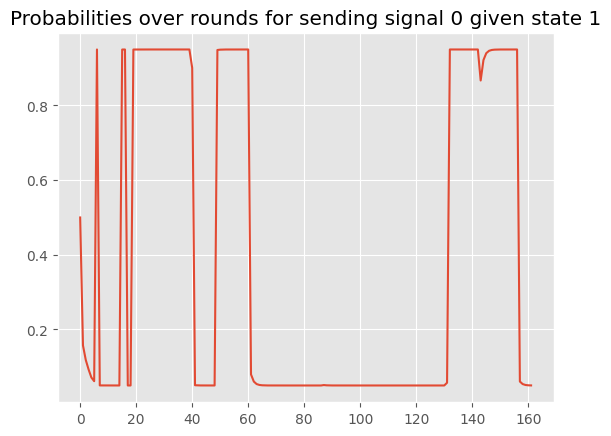

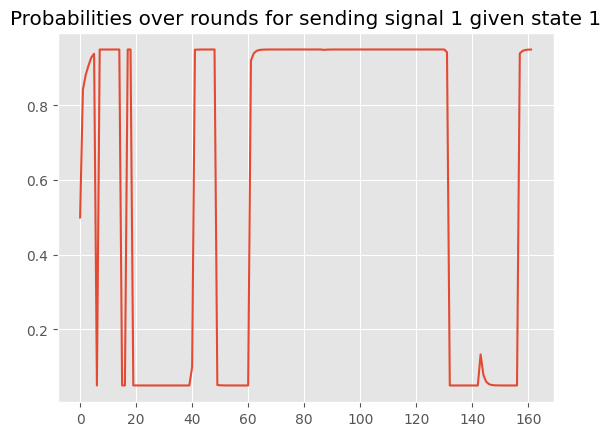

In [ ]:
import matplotlib.pyplot as plt


fig1, ax1 = plt.subplots()
ax1.plot(range(len(zero_zero_probs)), zero_zero_probs)
ax1.set_title("Probabilities over rounds for sending signal 0 given state 0")

fig2, ax2 = plt.subplots()
ax2.plot(range(len(zero_one_probs)), zero_one_probs)
ax2.set_title("Probabilities over rounds for sending signal 1 given state 0")

fig3, ax3 = plt.subplots()
ax3.plot(range(len(one_zero_probs)), one_zero_probs)
ax3.set_title("Probabilities over rounds for sending signal 0 given state 1")

fig4, ax4 = plt.subplots()
ax4.plot(range(len(one_one_probs)), one_one_probs)
ax4.set_title("Probabilities over rounds for sending signal 1 given state 1")


In [ ]:
def BP_QL(num_episodes, prior_dist, discount_factor = .6, alpha = 0.6, epsilon = 0.9):
    """
    Muti-agent RUQL algorithm. Designed based on above Q-Learning script from GeeksForGeeks
    """

    #Creates lists corresponding to each agent's Q tables, stats, and policy functions
    Q = []
    policy = []

    #Loop through each agent in the environment
    for i in range(2):

      #Generate a new Q table for each agent
      Q.append(defaultdict(lambda: np.zeros(2)))

      # Create an epsilon greedy policy function for each agent
      # appropriately for environment action space
      policy.append(createEpsilonGreedyPolicy(Q[i], epsilon, 2))

    states = [np.random.choice([0, 1], p=prior_dist), 0]
    next_states = states
    index = 0
    actions = [0, 0]
    for ith_episode in range(num_episodes):
        #print("On round: ", ith_episode)
        if ith_episode > 0:
          alpha = 1/(ith_episode)
        #loops through each agent
        if ith_episode % 2 == 0:
          index = 0
        else:
          index = 1
          states[1] = actions[0]

        policy[index] = createEpsilonGreedyPolicy(Q[index], epsilon, 2)

        action_probabilities = policy[index](states[index])
        if index == 0:
          print("Prosecutor action probabilities: ", action_probabilities)

        action = np.random.choice(np.arange(
                  len(action_probabilities)),
                  p = action_probabilities)


        if index == 0:
          print("Prosecutor took action ", action, " on episode ", ith_episode)

        actions[index] = action

        if index == 1:
          #pass action probabilities for each agent into env.step, which will update agent states state and environments by picking certain action given probabilities
          rewards = reward(actions[0], actions[1])
          #choose action given probabilities for each agent

          for i in range(2):
            action = actions[i]
            if i == 0:
              next_states[0] = np.random.choice([0, 1], p=prior_dist)
            else:
              action_probabilities = policy[0](next_states[0])
              action = np.random.choice(np.arange(
                        len(action_probabilities)),
                        p = action_probabilities)
              next_states[1] = action

            best_next_action = np.argmax(Q[i][next_states[i]])
            td_target = rewards[i] + discount_factor * Q[i][next_states[i]][best_next_action]
            td_delta = td_target - Q[i][states[i]][action]
            Q[i][states[i]][action] += alpha * td_delta

          #print(Q[0][0])

          states = next_states

    return Q



#reward(1, 1)

#BP_Q = BP_QL(1000, prior_dist)

#OSMD Algorithm

In [52]:
import itertools
import math
import matplotlib
import matplotlib.style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def proj(x):
  return np.exp(x)/(np.sum(np.exp(x)))

def OSMD(n, eta, delta, T, num_follower_actions=1):
  regret_vals = []
  utility_vals = []
  util = np.random.rand(num_follower_actions, n)
  optimal_pure_val = np.max(util)
  y = []
  while True:
    y = np.random.rand(n)
    max_index = -math.inf
    max_val = -math.inf
    for j in range(num_follower_actions):
      cur_u = np.dot(y, util[j])
      if cur_u > max_val:
        max_val = cur_u
        max_index = j


  for t in range(T):
    for i in range(num_follower_actions):
      #Compute utility of mixed strategy for each follower action and choose best response
      a_0_u = np.dot(util[0], proj(y))
      a_1_u = np.dot(util[1], proj(y))
      if a_0_u > a_1_u:
        follower_action = 0
        u = a_0_u
      else:
        follower_action = 1
        u = a_1_u
      utility_vals.append(u)
      regret_vals.append(u - optimal_pure_val)
      #Do OSMD on y
      v = np.random.rand(n)
      v *= 1/np.sum(v)
      x_1 = proj(y + eta*v)
      #Compute new utilities based on new mixed strategies
      a_0_u_prime = np.dot(util[0], x_1)
      a_1_u_prime = np.dot(util[1], x_1)
      if a_0_u_prime > a_1_u_prime:
        u_prime = a_0_u_prime
        follower_action_prime = 0
      else:
        u_prime = a_1_u_prime
        follower_action_prime = 1
      if u_prime > u:
        y += v*delta
      elif u_prime < u:
        y += v*(-delta)

  print("Final utility: ", utility_vals[T-1])
  print("Final regret: ", regret_vals[T-1])
  return regret_vals, utility_vals

regret, util = OSMD(10, 1, 1, 150)

f1 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(regret)
plt.show()


KeyboardInterrupt: 